Piecewise-cubic approximation of letterform SDFs
====

I came up with an interesting possible way to render letterforms
in simple hardware
driving a CRT.
The fundamental idea is that, as with [Chris Green's popular decal
technique][2], you're thresholding an approximation to a
two-dimensional signed distance function (SDF)
to figure out which pixels
to turn on, off, or partway on.
As with Green's technique, it permits
a relatively-low-resolution sampled representation
to be scaled, rotated, sheared, outlined,
and dilated or eroded somewhat
with minimal artifacts.

[2]: http://web.archive.org/web/20120217211316/https://www.valvesoftware.com/publications/2007/SIGGRAPH2007_AlphaTestedMagnification.pdf "Improved Alpha-Tested Magnification for Vector Textures and Special Effects"

The difference is:

1. The SDF approximation is piecewise cubic
   rather than piecewise linear,
   so the outlines of the letterforms are smooth rather than polygonal.
   However, this means current GPU texture mapping units
   cannot directly provide samples from the approximate SDF.
2. The approximation is being computed directly in the screen coordinate
   space rather than texel coordinates $(u, v)$ produced by
   a perspective transformation, so it can be computed without any
   multiplication, though, again, not in a pixel shader.

An SDF is a function that tells you how far outside a shape you are.
In this case it's a function in $\mathbb{R}^2 \to \mathbb{R}$
which tells you, for a given point in the 2-D plane,
how far outside a letterform you are.  It's 0 precisely at the border
of the letterform.  Inside the letterform, it's negative.

Computing a bitmap of a letterform
------

Let's start by calculating an approximate SDF of a letterform.
Actually, let's start by computing a bitmap of a letterform,
using Nicolas Rougier's [freetype-py][1].

[1]: https://freetype-py.readthedocs.io/en/latest/screenshots.html

In [1]:
%pylab inline
rcParams['figure.figsize'] = 12, 4

Populating the interactive namespace from numpy and matplotlib


In [2]:
import freetype  # from Ubuntu package python3-freetype

Let's try the [usage example from the docs][3].

[3]: https://freetype-py.readthedocs.io/en/latest/usage.html

In [3]:
# Font from Ubuntu package ttf-bitstream-vera
fontfile = "/usr/share/fonts/truetype/ttf-bitstream-vera/Vera.ttf"
face = freetype.Face(fontfile)
face.set_char_size(48*64)
face.load_char('&')
bitmap = face.glyph.bitmap
print(str(bitmap.buffer)[:64])

[0, 0, 0, 0, 0, 0, 0, 0, 4, 86, 158, 213, 236, 251, 239, 218, 17


That seems to have been successful, but it's a little hard to tell
visually what the `&` looks like.

In [4]:
len(bitmap.buffer)

1221

Hmm, that's not 48×64.  PARI/GP `factor(1221)` tells me it factors as
$3\times 11 \times 37$, so it could be 33×37 or 37×33, but nothing else
is close to square.

In [5]:
3*11*37

1221

In [6]:
face.glyph.metrics.height, face.glyph.metrics.width

(2368, 2112)

That doesn't seem helpful either.

In [7]:
face.glyph.format

1651078259

Neither does that.  I'll try guessing the dimensions.

In [8]:
array(bitmap.buffer).reshape((33, 37))

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0, 133, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 168,  10, ...,   0,   0,   0],
       [118, 255, 255, ..., 117, 255, 255],
       [255, 255, 255, ...,   0,   0,   0]])

That doesn't look right; it has a lot of discontinuities.

In [9]:
img = array(bitmap.buffer).reshape((37, 33))
img

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 122,   0],
       [  0,   0,   0, ..., 255, 255, 118],
       [  0,   0,   0, ...,   0,   0,   0]])

That seems more plausible?

(0, 255)

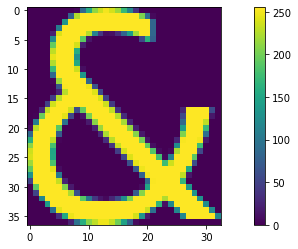

In [10]:
imshow(img)
colorbar()
img.min(), img.max()

Approximating its SDF by relaxation
---------------------------------------------------

Well, that's definitely an ampersand.  Let's set to computing its SDF.
The pixels that are 255 are inside, so they have value 0.
(Or less, since the SDF is negative inside the shape,
but for now we don't care about less.)  Ideally we'd use the nice
antialiasing freetype-py is doing for us, but this is simpler
and good enough to see if the approach works.

(0, 1)

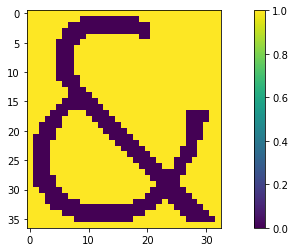

In [11]:
outside = (img != 255).astype(int)
imshow(outside)
colorbar()  # XXX warns nasty without the .astype(int)
outside.min(), outside.max()

Let's try computing a conservative approximation to the SDF
and relaxing it until we converge to the actual SDF,
at least for outside pixels.

818


(0, 30)

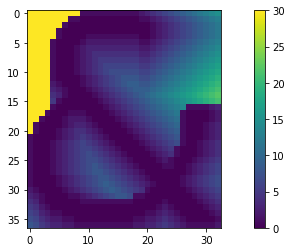

In [12]:
sdf = outside.copy()
sdf = where(sdf == 0, 0, 30)  # 30 is higher than any correct value

def relax_sdf(sdf):
    ww, hh = sdf.shape
    n = 0
    for y in range(hh):
        for x in range(ww):
            p = sdf[x, y]
            c = p
            if x > 0:
                c = min(c, sdf[x-1, y] + 1)
            if x < ww-1:
                c = min(c, sdf[x+1, y] + 1)
            if y > 0:
                c = min(c, sdf[x, y-1] + 1)
            if y < hh-1:
                c = min(c, sdf[x, y+1] + 1)
            if c != p:
                sdf[x, y] = c
                n += 1
    return n

print(relax_sdf(sdf))
imshow(sdf)
colorbar()
sdf.min(), sdf.max()

74


(0, 30)

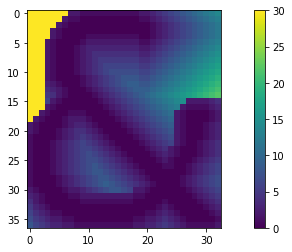

In [13]:
print(relax_sdf(sdf))
imshow(sdf)
colorbar()
sdf.min(), sdf.max()

56
43
39
24
17
14
13
5
3
0


(0, 14)

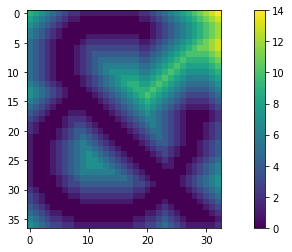

In [14]:
for i in range(10):
    n = relax_sdf(sdf)
    print(n)
    if n == 0:
        break

imshow(sdf)
colorbar()
sdf.min(), sdf.max()

Okay, that's pretty much the correct SDF for the outside pixels,
except that it's using the Manhattan distance metric,
and that's a slow way to compute it.  But it should be enough
for things like a crude approximation to a bold ampersand:

2.977886977886978

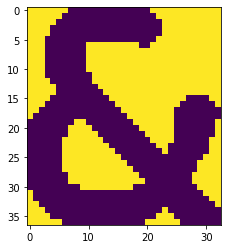

In [15]:
imshow(sdf > 2)
sdf.mean()

We can calculate the interior SDF in the same way
with the opposite sign:

316
15
0


(-14, 2)

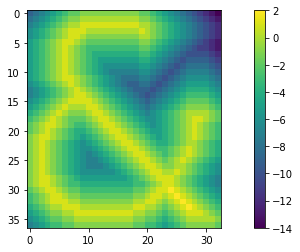

In [16]:
msdf = where(sdf == 0, 100, -sdf)
print(relax_sdf(msdf))
print(relax_sdf(msdf))
print(relax_sdf(msdf))
imshow(msdf)
colorbar()
msdf.min(), msdf.max()

2.8673218673218672

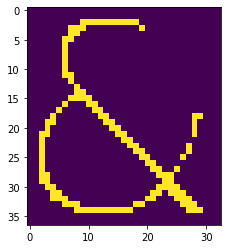

In [17]:
sdf = -msdf
imshow(sdf < 0)
sdf.mean()

Calculating its SDF by brute force
------------------------------------------------

Green's original paper suggests a different way to compute the SDF:
just using exhaustive search.
Here's an even simpler version of Green's approach:

In [18]:
def exhaustive_sdf(inside):
    rows = len(inside)
    cols = len(inside[0])
    resultsq = zeros((rows, cols))
    for row in range(rows):
        for col in range(cols):
            resultsq[row, col] = min((row-i)**2 + (col-j)**2
                                     for i in range(rows)
                                     for j in range(cols)
                                     if inside[i, j])
    return resultsq**.5

Although that's 1.4 million inner-loop iterations
in interpreted, it's plenty fast for these tests:

In [19]:
%time
esdf = exhaustive_sdf(outside == 0)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 12.2 µs


(0.0, 12.165525060596439)

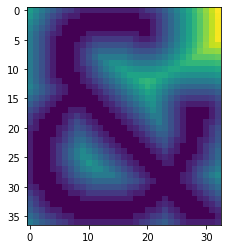

In [20]:
imshow(esdf)
esdf.min(), esdf.max()

In [21]:
isdf = exhaustive_sdf(outside)
rsdf = where(-isdf < 0, -isdf, esdf)
subplot(121); imshow(rsdf)
subplot(122); imshow(sdf)
rsdf.min(), rsdf.max()

(-2.23606797749979, 12.165525060596439)

That's a more accurate SDF, I think?  You get rounder contours:

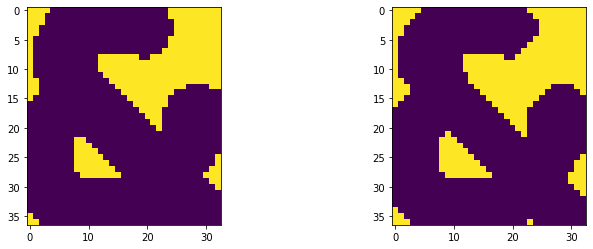

In [22]:
subplot(121); imshow(rsdf > 4)
subplot(122); _ = imshow(sdf > 4)

Some scan lines from the SDF
-------------------------------------------

Let's look at some of the scan lines we want to try to approximate
with piecewise cubics.  The intuition is that something like 4&ndash;6
spline knots along each of these scan lines should be enough to do
a reasonable job of approximating them,
at least for the purpose of approximating their zeroes.

In [23]:
plot(rsdf[5], label='line 5')
plot(rsdf[20], label='line 20')
plot(rsdf[35], label='line 35')
legend()
for i in range(5):
    axvline((i+.5)/5*33)
_ = axhline(0)

Clearly just sampling them at those points is not going to be
good enough; line 5 wouldn't have any zeroes at all.
But probably actually taking the dot product with the relevant spline
bits would be good enough.
And something like a simple optimization algorithm
that tries to maximize the places where the approximation
has the right sign
would probably be able to give quite a reasonable approoximation.

Some notes on cubic splines
-----------------------------------------

A cubic spline is a piecewise-cubic function
whose third derivative is constant except at so-called "knots",
where it fails to exist,
and whose second, first, and zeroth derivative
are continuous everywhere.

(In what follows, I assume the knots are equally spaced,
a so-called cardinal spline.
Often non-cardinal splines are considered, along with the
possibility of having two knots in the same place, which permits
discontinuities.)

This is easily approximated in discrete space
by the fourth-order prefix sum of a function that is zero
everywhere except at the knots:

In [55]:
%time
s4 = zeros(512)
s4[::64] = [-10, 40, -60, 40, -8, -4, 0, 0]
s3 = s4.cumsum()
s2 = s3.cumsum()
s1 = s2.cumsum()
s0 = s1.cumsum()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


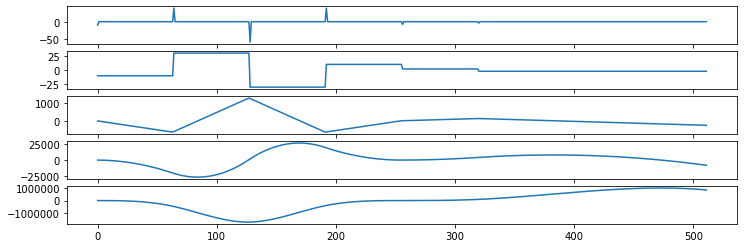

In [56]:
subplot(511); plot(s4)
subplot(512); plot(s3)
subplot(513); plot(s2)
subplot(514); plot(s1)
subplot(515); _ = plot(s0)

We can see here that it takes about 16 nanoseconds per sample with Numpy
to calculate this; probably 2 nanoseconds would be closer to
the capabilities of the hardware.  Since this is a linear,
time-invariant transformation on the original impulse sequence,
the linear transformation from the impulse sequence to the final
smooth wave is the circulant matrix of the impulse response,
which is unfortunately infinite:

22500864.0

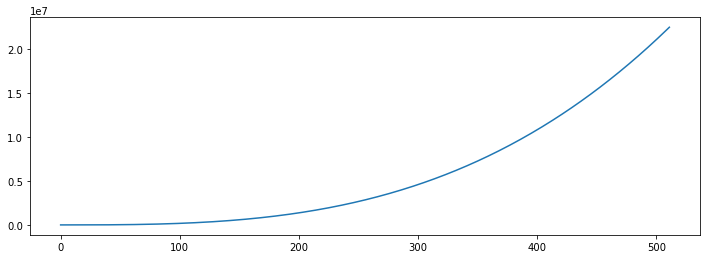

In [61]:
i4 = zeros(512)
i4[0] = 1
i4cs = i4.cumsum().cumsum().cumsum().cumsum()
plot(i4cs)
i4cs.max()

The brute-force approach to finding, say, the 8 samples that best
approximate a desired 512-sample signal
after being run through this gauntlet,
would be to make up the 8×512 matrix representing
that linear transformation,
and then computing its pseudoinverse.
I'm not sure this will work well because the matrix will be ill-conditioned.

A slightly more complicated approach
which I am sure will work well
is to compute a sinc-like wavelet spline
called a "basis spline"
which is 1 at one knot and 0 at all other knots;
then, instead of directly transforming our function into the 
space of coefficients for the impulses
at the knots,
we transform it into a space of coefficients at the knots
to be convolved with the basis spline.
These coefficients can then be transformed back into the space
of coefficients for the impulses,
which is a small 4×4 matrix.


*XXX draw the rest of the owl*